In [1]:
import numpy as np 
import torch

from PPO_file import PPO
from IMP_CW_env import MESCEnv
from utils import plot_reward_evolution, read_log_file, plot_reward_distribution

%matplotlib inline
%matplotlib ipympl
import matplotlib.pyplot as plt

# **1. Training environment definition**

In [2]:
n_retailers = 2
n_DCs = 1
n_suppliers = 1
supply_chain_structure = [[n_retailers] , [n_DCs], n_suppliers]

env_train = MESCEnv(supply_chain_structure)

# **2. PPO policy optimization**
### **2.1. Initialization:** define environment and PPO algorithm hyperparameters
Note that action space is handled as if it were continuous. Hence, actor's output represents the mean value of a multivariate normal random variable. Every time we want to sample an action from the actor's policy network, we will sample it from the multivariate normal distribution. For this reason, an initial standard deviation `action_std_init` is assumed, which is progressively decreased at a fixed `decay_rate` every `decay_freq` environment time steps.

In [3]:
num_states = env_train.observation_space.shape[0]
num_actions = env_train.action_space.shape[0]

num_epochs = 20 # Number of actor and critic network updates per batch of data
max_train_steps =  50 * env_train.n_periods # Stopping criteria: number of environment time steps that PPO algorithm will be executed
update_timestep = env_train.n_periods * 5 # How often to update actor and critic networks

lr_actor = 0.00005
lr_critic = 0.0001

eps_clip = 0.2 # Value of epsilon in PPO clipping
gamma = 0.99 # Discount factor to evaluate return

action_std_init = 0.5
decay_freq = 1000
decay_rate = 0.03
action_std_min = 0.05

log_freq = 1 # Number of episodes after which the log file is updated

### **2.2. Training**: implement PPO algorithm
First, create a PPO agent specifying all the hyperparameters defined above. These objects come with built-in functions to facilitate the development of the coursework <span style="color:red">(...)</span>.

<span style="color:red">**TO DO:**</span> An minimum explanation of how it works and how should they use it to implement the training function should be included.

In [4]:
PPOagent = PPO( num_states, num_actions, lr_actor, lr_critic,
                action_std_init=action_std_init, decay_freq=decay_freq, decay_rate=decay_rate, action_std_min=action_std_min,
                num_epochs=num_epochs, gamma=gamma, eps_clip=eps_clip, max_train_steps=max_train_steps, update_timestep=update_timestep,
                log_freq=log_freq)

In [5]:
print(PPOagent.policy.actor[0].weight)

Parameter containing:
tensor([[ 0.2644, -0.1249, -0.4249,  0.0308],
        [ 0.4660, -0.2230, -0.1628,  0.3910],
        [-0.0696, -0.1910, -0.1007,  0.0183],
        ...,
        [-0.2996, -0.0896,  0.3484, -0.4994],
        [-0.3303, -0.0831,  0.1788,  0.0909],
        [-0.1150,  0.2402, -0.3722,  0.4199]], requires_grad=True)


- <span style="color:red">**TO DO:**</span> In the next cell, students will be encouraged to write their own PPO implementation instead of calling the built-in train method. In fact, it could/should be removed upon deployment.
- An additional idea is that they implement both the `train` and `update` methods. They could write the functions, and these functions will be subsequently set in the parent `PPOagent` object.
```python
def train(PPOagent, env, logging = True, verbose = False):
    # Logging set up (lines of code that shouln't be changed)

    # PPO algorithm (can be modified)

    # Lines of code to close logging file and save model weights

    return actor_model_path, log_file_path

train(PPOagent, env_train, logging = True, verbose)
```

In [6]:
actor_model_path, log_file_path = PPOagent.train(env_train, logging=True, verbose = False)

Actor model weights saved in: ActorModels//PPO_ActorModel_15.pt
Log file saved in: PPO_logs//PPO_log_18.csv


### **2.3 Visualization:** plot reward evolution during training
If the data to be plotted is in a log file, please, indicate the appropiate file to be read in the cell below.

In [7]:
timesteps, rewards = read_log_file(log_file_path)

Run the following cell to visualize the plot. Take into account that `timesteps` and `rewards` should be one-dimensional arrays or lists.

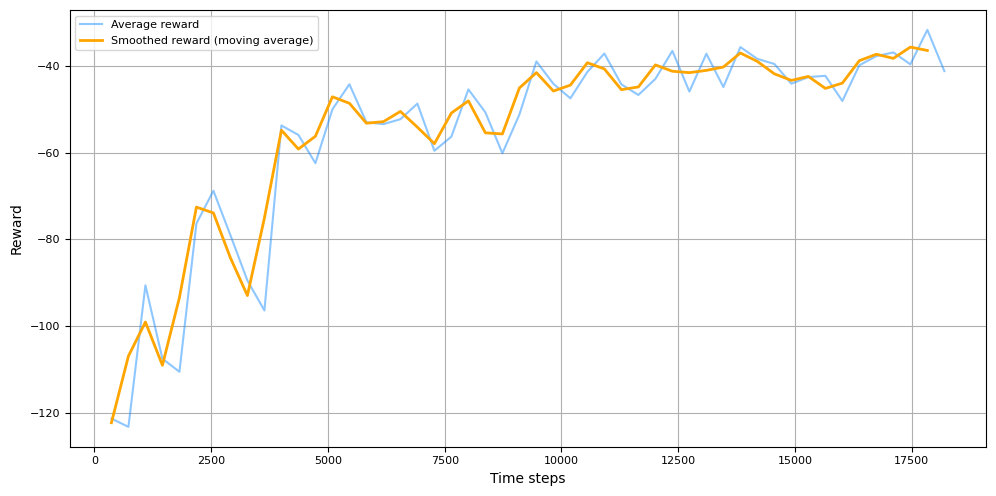

In [8]:
plot_reward_evolution(timesteps, rewards)

# **3. PPO policy evaluation**
### **3.1. Test data**: generate new demand scenarios
It will contain 100 samples for testing, each with 52 weeks.

In [ ]:
test_demand_dataset = []
env_train.seed = 42
for _ in range(0,100):
    demands_episode, _ = env_train.sample_demands_episode()
    test_demand_dataset.append(demands_episode)

### **3.2. Load policy**
If the last trained model is not to be tested, specify the appropriate path to the actor model in the variable `actor_model_path`.

In [ ]:
PPOagent.policy_old.actor.load_state_dict(torch.load(r"C:\Users\Isabela\Desktop\GitHubRepos\courseworkRL\ActorModels\PPO_ActorModel.pt"))
PPOagent.policy.actor.load_state_dict(torch.load(r"C:\Users\Isabela\Desktop\GitHubRepos\courseworkRL\ActorModels\PPO_ActorModel.pt"))

### **3.3. Evaluation:** define the test function

In [ ]:
reward_list = PPOagent.evaluate_policy(env_train, test_demand_dataset)

Compare to heuristic policy.

In [ ]:
from HeuristicPolicy_file import HeuristicPolicy

sSpolicy = HeuristicPolicy()
sSpolicy.policy_param = np.array([16., 49., 15., 50., 65., 199.])
reward_list_sS = sSpolicy.evaluate_policy(env_train, test_demand_dataset)

In [ ]:
from utils import plot_reward_distribution
# plot_reward_distribution(np.vstack([reward_list,reward_list_sS]).T, labels=['PPO', 'sS policy'])
plot_reward_distribution(reward_list, labels=['PPO'])
plot_reward_distribution(reward_list_sS, labels=['sS policy'])